In [30]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

from sklearn.metrics import log_loss
from sklearn import metrics
from sklearn import model_selection
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

% matplotlib inline

In [2]:
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

# Import data

In [3]:
store = pd.HDFStore('store.h5')
members = store['members']
training = pd.read_csv('data/churn_comp_refresh/train_v2.csv')
sample_submission = pd.read_csv('data/churn_comp_refresh/sample_submission_v2.csv')

In [4]:
# select only the intersection between training and members tables
members_training = members.merge(training, on='msno', how='inner')

# Create validation dataset

In [5]:
X = np.array(members_training.iloc[:, 1:-1])
X_columns = members_training.iloc[:, 1:-1].columns
y = np.array(members_training.iloc[:, -1])

In [41]:
X

array([[-1,  1,  1, ...,  1,  0,  0],
       [63,  0,  0, ...,  0,  1,  0],
       [-1,  1,  1, ...,  1,  0,  0],
       ..., 
       [-1,  1,  1, ...,  1,  0,  0],
       [26,  0,  0, ...,  1,  0,  0],
       [-1,  1,  1, ...,  1,  0,  0]])

In [6]:
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, y, test_size=0.2, random_state=0)

# Build and assess different models

In [34]:
# baseline logloss if we predict all members as base rate
BASE_RATE = sum(training['is_churn'])/len(training)
y_predict = np.full(len(y), BASE_RATE)
baseline_logloss = -log_loss(y, y_predict)
print('baseline logloss: {}'.format(baseline_logloss))

baseline logloss: -0.1375862975682978


In [7]:
models = [
    ('Logistic regression', LogisticRegression()),
    ('LDA', LinearDiscriminantAnalysis()),
    ('KNN', KNeighborsClassifier()),
    ('CART', DecisionTreeClassifier()),
    #('SVM', SVC()),
    ('XGB', XGBClassifier())
]

In [10]:
names = [m[0] for m in models]

In [8]:
results = []
for name, model in models:
    logging.info('Evaluating {}'.format(name))
    kfold = model_selection.KFold(n_splits=10, random_state=0)
    cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring='neg_log_loss')
    results.append(cv_results)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

INFO:root:Evaluating Logistic regression
INFO:root:Evaluating LDA


Logistic regression: -0.082934 (0.001083)


/Users/lintaylor/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/lintaylor/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/lintaylor/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/lintaylor/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/lintaylor/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/lintaylor/.pyenv/versions/3.6.0/lib/python3.6/site-package

LDA: -0.085369 (0.000958)


INFO:root:Evaluating CART


KNN: -0.522944 (0.016099)


INFO:root:Evaluating XGB


CART: -1.021743 (0.019660)
XGB: -0.078647 (0.000888)


XGboost has the smallest logloss (performs the best out of the models trialled)

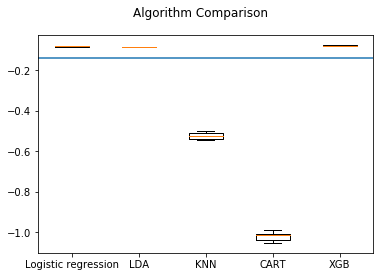

In [38]:
# blue line at baseline logloss
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
ax.axhline(y=baseline_logloss)
plt.show()

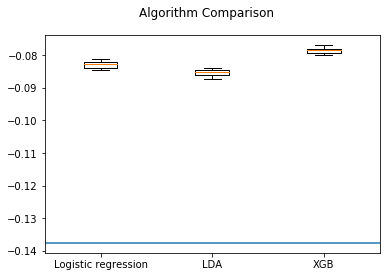

In [37]:
# blue line at baseline logloss
best_indices = [0, 1, 4]
best_results = [results[i] for i in best_indices]
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(best_results)
ax.set_xticklabels([names[i] for i in best_indices])
ax.axhline(y=baseline_logloss)
plt.show()

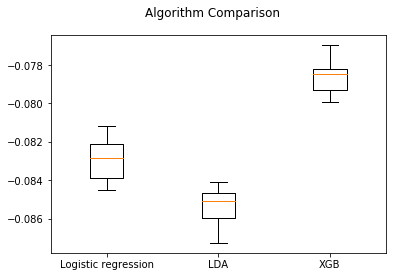

In [39]:
best_indices = [0, 1, 4]
best_results = [results[i] for i in best_indices]
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(best_results)
ax.set_xticklabels([names[i] for i in best_indices])
plt.show()

# Use best model to make predictions on validation set

In [47]:
xgb = XGBClassifier()
xgb.fit(X_train, Y_train)
predictions = xgb.predict_proba(X_validation)
log_loss(Y_validation, predictions)


0.077944769655201973

In [ ]:
# Retrain the model on the whole dataset